In [2]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from collections import defaultdict, Counter
from itertools import combinations
from tqdm.notebook import tqdm_notebook
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [3]:
p_data = Path("/home/simonjisu/code/data/kaggle_movie/")

In [34]:
df_movie_meta = pd.read_csv(p_data / "preprocessed_movie_meta.tsv", sep="\t")
df_movie_meta.columns

Index(['movieId', 'imdbId', 'title', 'release_cate', 'genres', 'runtime',
       'production_countries', 'spoken_languages', 'status', 'adult',
       'popularity', 'vote_average', 'vote_count', 'revenue', 'overview'],
      dtype='object')

In [94]:
df_movie_meta.drop(index=df_movie_meta.loc[df_movie_meta.duplicated("title") & df_movie_meta.duplicated("movieId"), :].index, inplace=True)

In [99]:
df_movie_meta = df_movie_meta.drop_duplicates("imdbId")

In [104]:
df_small = pd.read_csv(p_data / "ratings_small.csv")

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


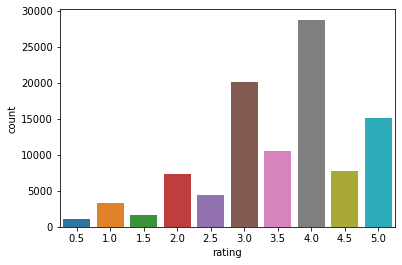

In [105]:
# 사람들이 얼마나 후하게 점수를 주는지 rating을 한번 봤음 
sns.countplot(df_small["rating"])
print(df_small["rating"].describe())

In [106]:
# 카테고리를 나눔
def rating_cate(x):
    if 0.0 <= x < 2.5: return "low_rater"
    elif 2.0 <= x < 3.5: return "small_rater"
    elif 3.5 <= x < 4.0: return "middle_rater"
    elif 4.0 <= x < 5.0: return "big_rater"
    else: return "none"


In [107]:
df_user = pd.DataFrame(df_small.groupby(["userId"])["rating"].mean().apply(rating_cate))

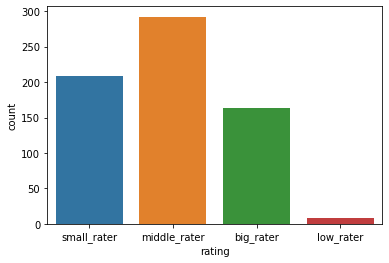

In [108]:
# 대부분 점수를 중박으로 주는 편
sns.countplot(x="rating", data=df_user)

In [225]:
# 영화번호 : 장르 사전
temp = df_movie_meta.loc[:, ("movieId", "genres")].set_index("movieId").copy()
temp.loc[:, "genres"] = temp.loc[:, "genres"].str.split("|")
temp_genres = temp.to_dict()["genres"]
movie2genres = defaultdict()
genres_unique = set()
for k, v in temp_genres.items():
    if not isinstance(v, list):
        movie2genres[k] = ["UNK"]
        genres_unique.add("UNK")
    else:
        movie2genres[k] = v
        for movie in v:
            genres_unique.add(movie)

In [216]:
flatten = lambda li: [x for inli in li for x in inli]
def get_genres(mids, movie2genres):
    for i in mids:
        if movie2genres.get(i):
            yield movie2genres.get(i)
        else:
            yield ["UNK"]

In [217]:
# top 3만 뽑아보자 
user_fav_genres = defaultdict()
for uid, mids in df_small.groupby(["userId"])["movieId"].apply(list).reset_index().values:
    user_fav_genres[uid] = Counter(flatten(list(get_genres(mids, movie2genres)))).most_common(3)

In [112]:
temp = pd.DataFrame(user_fav_genres).T
cols = {i: v for i, v in enumerate(["fv1", "fv2", "fv3"])}
cols["index"] = "userId"
temp = temp.reset_index().rename(columns=cols)

In [113]:
df_user_final = pd.merge(df_user, temp, on="userId")

In [114]:
df_user_final.to_csv(p_data / "df_user.tsv", sep="\t")

In [115]:
cols = ["movieId", "title", "genres", "release_cate", "popularity", "vote_average", "revenue", "vote_count"]
df_meta_to_use = df_movie_meta.loc[:, cols]
df_meta_to_use.isna().sum(0)

movieId          0
title            0
genres          30
release_cate     1
popularity       0
vote_average     0
revenue          0
vote_count       0
dtype: int64

In [116]:
df_movie_meta.loc[df_movie_meta.movieId==77658, :]

,movieId,imdbId,title,release_cate,genres,runtime,production_countries,spoken_languages,status,adult,popularity,vote_average,vote_count,revenue,overview
7668,77658,81846,Cosmos,NaN,NaN,60.0,NaN,NaN,Released,False,0.282584,9.1,41,0,"""Astronomer Dr. Carl Sagan is host and narrato..."


In [117]:
# 칼 세이건의 코스모스라서 그냥 넣어줌
df_meta_to_use.loc[df_meta_to_use.release_cate.isna(), "release_cate"] = "1976-1995"
# 장르 없는건 "UNK" 로 넣어줌
df_meta_to_use.loc[df_meta_to_use.genres.isna(), "genres"] = "UNK"

In [118]:
df_meta_to_use.to_csv(p_data / "df_meta.tsv", sep="\t", index=False)

In [119]:
df_meta_to_use.head()

,movieId,title,genres,release_cate,popularity,vote_average,revenue,vote_count
0,1,Toy Story,Animation|Comedy|Family,1976-1995,21.946943,7.7,373554033,5415
1,2,Jumanji,Adventure|Fantasy|Family,1976-1995,17.015539,6.9,262797249,2413
2,3,Grumpier Old Men,Romance|Comedy,1976-1995,11.712900,6.5,0,92
3,4,Waiting to Exhale,Comedy|Drama|Romance,1976-1995,3.859495,6.1,81452156,34
4,5,Father of the Bride Part II,Comedy,1976-1995,8.387519,5.7,76578911,173


In [120]:
# similarity
# genres one-hot vector
df_g = df_meta_to_use.genres.str.split("|")
genres = set()
for x in df_g:
    for y in x:
        genres.add(y)
s_genres = sorted(list(genres))
s_genres.remove("UNK")
g2idx = defaultdict()
g2idx["UNK"] = 0
for i, v in enumerate(s_genres, 1):
    g2idx[v] = i
idx2g = {i: g for g, i in g2idx.items()}
gg = df_g.apply(lambda x: [g2idx.get(i) for i in x])
v = np.zeros((len(gg), len(g2idx)))
for i, g in enumerate(gg):
    for j in g:
        v[i, j] = 1
b = np.hstack([df_meta_to_use["movieId"].values.reshape(-1, 1), v])

In [121]:
pd.DataFrame(b, columns=["movieId"] + list(g2idx.keys()))\
    .astype(int).to_csv(p_data / "df_movie_genres.csv", index=False)

In [268]:
# 전체 user 각 장르별 본 영화 횟수
user_fav_genres = defaultdict()
for uid, mids in df_small.groupby(["userId"])["movieId"].apply(list).reset_index().values:
    user_fav_genres[uid] = Counter(flatten(list(get_genres(mids, movie2genres))))

# similarity 구하기
df_user_genres_counts = pd.DataFrame(user_fav_genres).T.fillna(0.0).astype(np.int).reset_index()
df_user_genres_counts.rename(columns={"index": "userId"}, inplace=True)
df_user_genres_counts.to_csv(p_data / "df_user_genres_counts.tsv", sep="\t", index=False)

In [275]:
temp = pd.DataFrame(df_small.groupby(["userId"])["rating"].mean()).reset_index()
df_users_genres_rating = pd.merge(temp, df_user_genres_counts, on="userId").set_index("userId")

In [276]:
user_cos = cosine_similarity(StandardScaler().fit_transform(df_user_genres_counts.values))
user_sim = pd.DataFrame(user_cos, columns=df_user_genres_counts.index, index=df_user_genres_counts.index)

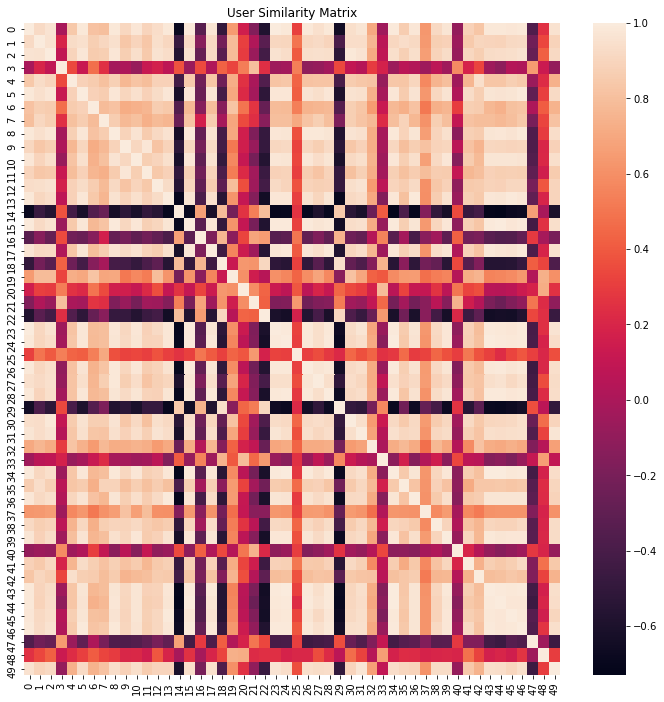

In [277]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(user_sim.iloc[:50, :50], ax=ax)
ax.set_title("User Similarity Matrix", fontsize=12)
plt.show()

In [278]:
selected_users = user_sim.index
for i, mid in tqdm_notebook(enumerate(selected_users), total=len(selected_users)):
    x = user_sim[mid]
    from_idx = np.argmax(x.index == mid)
    idx = x.index[(from_idx+1):]
    values = x.values[(from_idx+1):]
    if i == 0:
        temp = np.vstack([np.ones(len(idx)).astype(np.int) * np.array([mid]), idx, values]).T
    else:
        new = np.vstack([np.ones(len(idx)).astype(np.int) * np.array([mid]), idx, values]).T
        temp = np.vstack([temp, new])

In [280]:
df_user_sim = pd.DataFrame(temp, columns=["user1", "user2", "similarity"])
df_user_sim["user1"] = df_user_sim["user1"].astype(int)
df_user_sim["user2"] = df_user_sim["user2"].astype(int)

In [282]:
df_user_sim.to_csv(p_data / "df_user_sim.csv", index=False)

In [123]:
# others
a = df_meta_to_use.loc[:, ("movieId", "release_cate", "popularity", "vote_average", "vote_count")]

release_dict = {'UNK': 0, '1900-1975':1,'1976-1995':2, '1996-2003':3, '2004-2009':4, '2010-':5}

a.release_cate = a.release_cate.apply(release_dict.get)
a.to_csv(p_data / "df_movie_others.csv", index=False)

In [124]:
# calculate movies similarities
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

mov_genres_df = pd.read_csv(p_data / "df_movie_genres.csv")
mov_others_df = pd.read_csv(p_data / "df_movie_others.csv")
cos_genres = cosine_similarity(StandardScaler().fit_transform(mov_genres_df.values))*0.5
cos_others = cosine_similarity(StandardScaler().fit_transform(mov_others_df.values))*0.5
cos = cos_genres+cos_others

movies_sim = pd.DataFrame(cos, columns=mov_genres_df.index.values, index=mov_genres_df.index)
movies_sim.head()

,0,1,2,3,4,5,6,7,8,9,...,7513,7514,7515,7516,7517,7518,7519,7520,7521,7522
0,1.000000,0.607718,0.117785,-0.247313,0.060008,0.333405,-0.048603,-0.134049,-0.214334,0.348403,...,-0.156958,-0.151103,-0.170856,-0.038998,-0.110694,-0.185830,0.134936,-0.190992,0.152416,-0.074003
1,0.607718,1.000000,0.114584,-0.339294,0.001005,0.360165,-0.087299,0.063736,0.020198,0.593647,...,-0.280270,-0.286369,-0.240726,-0.059517,-0.167653,-0.241480,0.253518,-0.261755,0.136113,-0.131514
2,0.117785,0.114584,1.000000,0.488342,0.613387,0.056801,0.827585,-0.166444,0.014507,0.222916,...,-0.170198,-0.366902,-0.480018,-0.203460,-0.312837,-0.410418,-0.134315,-0.478862,-0.039747,-0.224076
3,-0.247313,-0.339294,0.488342,1.000000,0.452102,-0.330532,0.814349,0.351531,0.225500,-0.322633,...,-0.133322,-0.333869,-0.451594,-0.532823,-0.329638,-0.375688,-0.643644,-0.374483,-0.223342,-0.219899
4,0.060008,0.001005,0.613387,0.452102,1.000000,-0.188059,0.715293,0.195362,0.369287,0.091629,...,-0.251442,-0.253834,-0.527736,-0.401398,-0.421455,-0.319607,-0.274739,-0.507275,-0.358133,-0.418075


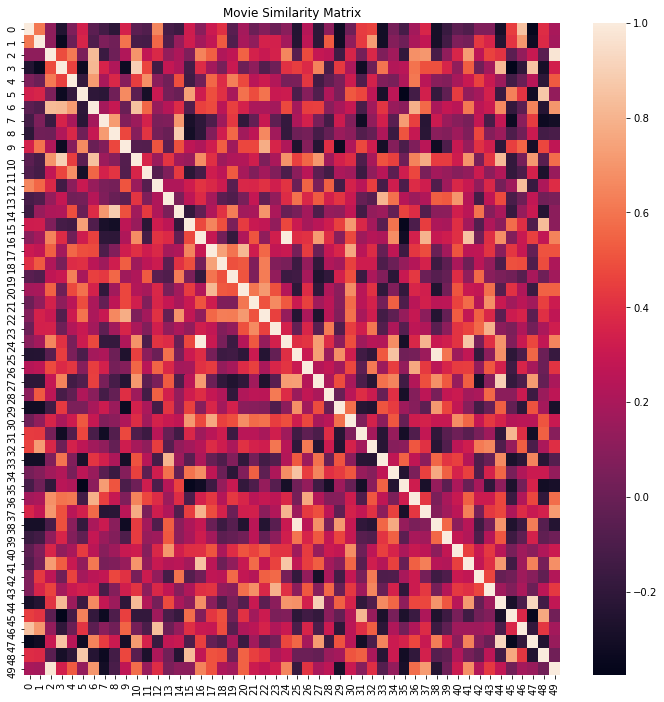

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(movies_sim.iloc[:50, :50], ax=ax)
ax.set_title("Movie Similarity Matrix", fontsize=12)
plt.show()

In [134]:
df_selected = mov_others_df.loc[mov_others_df["release_cate"]>=3, :]
selected_movies = df_selected.index
selected_movies_sim = movies_sim.loc[selected_movies, selected_movies]

In [207]:
for i, mid in tqdm_notebook(enumerate(selected_movies), total=len(selected_movies)):
    x = selected_movies_sim[mid]
    from_idx = np.argmax(x.index == mid)
    idx = x.index[(from_idx+1):]
    values = x.values[(from_idx+1):]
    if i == 0:
        temp = np.vstack([np.ones(len(idx)).astype(np.int) * np.array([mid]), idx, values]).T
    else:
        new = np.vstack([np.ones(len(idx)).astype(np.int) * np.array([mid]), idx, values]).T
        temp = np.vstack([temp, new])

In [209]:
df_sim = pd.DataFrame(temp, columns=["movie1", "movie2", "similarity"])
df_sim["movie1"] = df_sim["movie1"].astype(int)
df_sim["movie2"] = df_sim["movie2"].astype(int)

In [211]:
df_sim.to_csv(p_data / "df_movie_sim.csv", index=False)

In [218]:
# user similarity
temp = pd.DataFrame(user_fav_genres).T

In [219]:
temp

,0,1,2
1,"(Drama, 7)","(Action, 6)","(Adventure, 6)"
2,"(Drama, 45)","(Comedy, 28)","(Romance, 24)"
3,"(Drama, 28)","(Comedy, 14)","(Adventure, 13)"
4,"(Comedy, 81)","(Adventure, 67)","(Drama, 56)"
5,"(Comedy, 52)","(Drama, 44)","(Romance, 32)"
...,...,...,...
667,"(Drama, 47)","(Comedy, 26)","(Romance, 22)"
668,"(Drama, 13)","(Crime, 8)","(Comedy, 6)"
669,"(Comedy, 16)","(Thriller, 11)","(Drama, 10)"
670,"(Drama, 20)","(Crime, 10)","(Thriller, 9)"


---

In [219]:
df_user_final.columns

Index(['userId', 'rating', 'fv1', 'fv2', 'fv3'], dtype='object')

In [58]:
df = pd.read_csv(p_data / "preprocessed_movie_meta.tsv", encoding="utf-8", sep="\t")

In [59]:
df.drop(columns=["Unnamed: 0"], inplace=True)

In [221]:
mov_genres_df = pd.read_csv("./movie_genres.csv")
mov_rating_df = pd.read_csv("./movie_vote_release.csv")

In [222]:
mov_genres_df = mov_genres_df.set_index('movieId')
mov_rating_df = mov_rating_df.set_index('movieId')

In [224]:
mov_rating_df

,release_cate,vote_average,vote_group
movieId,,,
1,2,7.7,5
2,2,6.9,4
3,2,6.5,2
4,2,6.1,2
5,2,5.7,3
...,...,...,...
159462,2,5.0,2
160563,5,5.5,4
161944,3,7.0,0


In [151]:
from sklearn.metrics.pairwise import cosine_similarity


In [152]:
cos_genres = cosine_similarity(mov_genres_df.values)*0.5
cos_rating = cosine_similarity(mov_rating_df.values)*0.5
cos = cos_genres+cos_rating

In [157]:
cols = mov_rating_df.index.values
inx = mov_rating_df.index
movies_sim = pd.DataFrame(cos, columns=cols, index=inx)
movies_sim.head()

,1,2,3,4,5,6,7,8,9,10,...,145307,147037,152057,152173,152844,159462,160563,161944,7502,77658
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.665818,0.684925,0.649184,0.784854,0.497735,0.699289,0.629509,0.496405,0.499390,...,0.664070,0.716154,0.443173,0.473662,0.468413,0.486314,0.456100,0.418530,0.484948,0.457298
2,0.665818,1.000000,0.487671,0.489175,0.498847,0.499403,0.498361,0.780059,0.665509,0.666562,...,0.470339,0.440886,0.454370,0.481174,0.474509,0.492221,0.664818,0.433561,0.491208,0.462010
3,0.684925,0.487671,1.000000,0.908107,0.845597,0.491512,0.994674,0.498702,0.490682,0.485716,...,0.995971,0.821769,0.472231,0.498614,0.491348,0.497279,0.449146,0.476975,0.498877,0.478069
4,0.649184,0.489175,0.908107,1.000000,0.782283,0.636802,0.904054,0.643754,0.492434,0.487450,...,0.903510,0.758658,0.678798,0.497590,0.489224,0.498375,0.454139,0.764194,0.666198,0.474961
5,0.784854,0.498847,0.845597,0.782283,1.000000,0.498606,0.853206,0.495931,0.499934,0.498594,...,0.832043,0.955877,0.467346,0.485342,0.475703,0.496839,0.468548,0.446797,0.495743,0.460448


In [159]:
movies_sim.to_csv("./movies_sim.csv", index=False)

In [136]:
a = df.loc[:, ("movieId", "release_cate", "vote_average", "vote_count")]
def set_rating_group(rating_counts):
    if (rating_counts <= 1): return 0
    elif (2 <= rating_counts <= 10): return 1
    elif (11 <= rating_counts <= 100): return 2
    elif (101 <= rating_counts <= 1000): return 3
    elif (1001 <= rating_counts <= 5000): return 4
    elif (5001 <= rating_counts): return 5
    else: return 0
a['vote_group'] = a['vote_count'].apply(set_rating_group)

In [137]:
a.release_cate.unique()

array(['1976-1995', '2010-', '1996-2003', '1900-1975', '2004-2009', nan],
      dtype=object)

In [138]:
a.release_cate = a.release_cate.fillna("UNK")

In [139]:
release_dict = {'UNK': 0, '1900-1975':1,'1976-1995':2, '1996-2003':3, '2004-2009':4, '2010-':5}

In [140]:
a.release_cate = a.release_cate.apply(release_dict.get)

In [141]:
a.drop(columns=["vote_count"], inplace=True)

In [142]:
a.to_csv("movie_vote_release.csv", index=False)

In [143]:
a

,movieId,release_cate,vote_average,vote_group
0,1,2,7.7,5
1,2,2,6.9,4
2,3,2,6.5,2
3,4,2,6.1,2
4,5,2,5.7,3
...,...,...,...,...
7664,159462,2,5.0,2
7665,160563,5,5.5,4
7666,161944,3,7.0,0
7667,7502,3,8.2,3


In [61]:
df["gg"] = df.genres.str.split("|", expand=False).fillna("UNK")

In [62]:
genres = set()
for x in df["gg"]:
    if x == "UNK":
        genres.add("UNK")
    else:
        for y in x:
            genres.add(y)

In [63]:
genres_dict = {g: i for i, g in enumerate(genres)}

In [51]:
df_temp = df.loc[:, ("movieId", "gg")]
df_temp.head()

,movieId,gg
0,1,"[Animation, Comedy, Family]"
1,2,"[Adventure, Fantasy, Family]"
2,3,"[Romance, Comedy]"
3,4,"[Comedy, Drama, Romance]"
4,5,[Comedy]


In [65]:
gg = df_temp.gg.apply(lambda x: [genres_dict.get(i) for i in x] if isinstance(x, list) else [genres_dict.get(x)])

dict_keys(['TV Movie', 'Horror', 'Animation', 'UNK', 'Adventure', 'Documentary', 'Action', 'Western', 'Family', 'Science Fiction', 'Fantasy', 'Mystery', 'Crime', 'War', 'History', 'Drama', 'Thriller', 'Foreign', 'Comedy', 'Romance', 'Music'])

In [82]:
v = np.zeros((len(df_temp), len(genres)))
for i, g in enumerate(gg):
    for j in g:
        v[i, j] = 1
b = np.hstack([df_temp["movieId"].values.reshape(-1, 1), v])

In [147]:
pd.DataFrame(b, columns=["movieId"] + list(genres_dict.keys())).astype(int).to_csv("movie_genres.csv", index=False)

In [97]:
pd.DataFrame(genres_dict.items(), columns=["genres_name", "genres_id"]).to_csv("movie_genres_dict.csv", index=False)